# Singing performance assessment

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

## Create balance pairs

- 256 positive pairs + 256 negative pairs
- Trim zeros from beginning and end

In [2]:
# read files
datapath = './f0data'
per_fail = []
per_pass = []
ref = []

for i in os.listdir(datapath):
    if i.endswith('pass.f0s.txt'):
        per_pass.append(datapath + '/' + i)
    elif i.endswith('fail.f0s.txt'):
        per_fail.append(datapath + '/' + i)
    else:
        ref.append(datapath + '/' + i)

# file name lists
per_pass = sorted(per_pass) # 266
per_fail = sorted(per_fail) # 730
ref = sorted(ref) # 2542

num_pass = len(per_pass)
num_fail = len(per_fail)
num_per = num_pass + num_fail
num_ref = len(ref)

print("Number of pass: ", num_pass)
print("Number of fail: ", num_fail)
print("Number of performances: ", num_per)
print("Number of reference: ", num_ref)

Number of pass:  266
Number of fail:  730
Number of performances:  996
Number of reference:  2542


In [3]:
# randomly choose 266 from 730 fails
np.random.seed(1234)
pick = np.random.choice(num_fail, num_pass, replace=False)
pick = sorted(pick)

per_fail_pick = np.array(per_fail)[pick] # 266 fail file name lists
per_filename = np.concatenate((per_pass, per_fail_pick)) # 532 performance file name lists

In [5]:
# performance f0 data
# only second column f0 data
# trim zeros from beginning and end
pass_f0 = [np.trim_zeros(np.loadtxt(file)[:,1]) for file in per_pass]
pass_f0 = np.array(pass_f0,dtype='object')
fail_f0 = [np.trim_zeros(np.loadtxt(file)[:,1]) for file in per_fail_pick]
fail_f0 = np.array(fail_f0,dtype='object')

per_f0 = np.concatenate((pass_f0, fail_f0)) # 532 performance f0

In [6]:
# create matching reference file name list
# find 532 reference files that pair with 532 performances
new_ref = ref.copy()
ref_match = [] # 532 reference file name list

for i in per_filename:
    identifier = i.split('per')[0]
    for j in new_ref:
        if j.split('ref')[0] == identifier:
            ref_match.append(j)
            new_ref.remove(j)
            break

In [7]:
# reference f0 data
# only second column f0 data
# trim zeros from beginning and end
ref_f0 = [np.trim_zeros(np.loadtxt(file)[:,1]) for file in ref_match]
ref_f0 = np.array(ref_f0,dtype='object') # 532 performance f0

## Train test split

In [8]:
# create labels
label = []
for i in range(num_pass):
    label.append(1)
for i in range(num_pass):
    label.append(0)

In [9]:
# train test split
num_data = num_pass * 2 # 532
np.random.seed(1234)
shuffle = np.random.permutation(num_data)
num_train = int(num_data * 0.8)

# training
per_f0_train = per_f0[shuffle][:num_train] # performance midi for training
ref_f0_train = ref_f0[shuffle][:num_train] # reference midi for training
y_train = np.array(label)[shuffle][:num_train] # training label


# testing
per_f0_test = per_f0[shuffle][num_train:] # performance midi for testing
ref_f0_test = ref_f0[shuffle][num_train:] # reference midi for testing
y_test = np.array(label)[shuffle][num_train:] # testing label

## Data prepocessing

- Convert f0 to midi

- Resample all singing and reference to same length

In [10]:
# convert f0 to midi (0hz stays 0 in midi)
# https://stackoverflow.com/questions/21752989/numpy-efficiently-avoid-0s-when-taking-logmatrix

def f0_to_midi(f0):
    midi_min = float('inf')
    midi_max = 0

    midi = np.copy(f0)
    for i, item in enumerate(f0):
        midi[i] = 12 * np.ma.log2(item/440) + 69
        midi[i] = midi[i].filled(0) # 532 midi
        midi_min = np.min([midi_min, np.min(midi[i][np.nonzero(midi[i])])])
        midi_max = np.max([midi_max, np.max(midi[i][np.nonzero(midi[i])])])
    return midi, midi_min, midi_max

per_midi_train, per_midi_min, per_midi_max = f0_to_midi(per_f0_train)
ref_midi_train, ref_midi_min, ref_midi_max = f0_to_midi(ref_f0_train)
print("per_midi_min", per_midi_min)
print("per_midi_max", per_midi_max)
print("ref_midi_min", ref_midi_min)
print("ref_midi_max", ref_midi_max)
    
    
# per_midi_min = float('inf')
# per_midi_max = 0

# per_midi_train = np.copy(per_f0_train)
# for i, f0 in enumerate(per_f0_train):
#     per_midi_train[i] = 12 * np.ma.log2(f0/440) + 69
#     per_midi_train[i] = per_midi_train[i].filled(0) # 532 ref midi
#     per_midi_min = np.min([per_midi_min, np.min(per_midi_train[i][np.nonzero(per_midi_train[i])])])
#     per_midi_max = np.max([per_midi_max, np.max(per_midi_train[i][np.nonzero(per_midi_train[i])])])
# print("per_midi_min", per_midi_min)
# print("per_midi_max", per_midi_max)

per_midi_min 43.460000618197
per_midi_max 77.42000006728594
ref_midi_min 53.01999941261086
ref_midi_max 74.42000055044677


In [11]:
# average lenghth of data
length = 0
for i,file in enumerate(per_midi_train):
    length += len(file)
avg_len_per = int(length/i)
print("average length for performances: ", avg_len_per)

length = 0
for i,file in enumerate(ref_midi_train):
    length += len(file)
avg_len_ref = int(length/i)
print("average length for references: ", avg_len_ref)

avg_len = int((avg_len_per + avg_len_ref)/2)
print("average length: ", avg_len)

average length for performances:  1647
average length for references:  1797
average length:  1722


In [12]:
# resample performance and reference to average length
def resample(midi, length):
    midi_res = np.copy(midi)
    for i, item in enumerate(midi):
        xp = np.arange(len(item))
        fp = item
        midi_res[i] = np.interp(np.linspace(0,len(item)-1,num=length), xp, fp)
    return midi_res

per_midi_res_train = resample(per_midi_train, avg_len)
ref_midi_res_train = resample(ref_midi_train, avg_len)

# per_midi_res_train = np.copy(per_midi_train)
# for i, item in enumerate(per_midi_train):
#     xp = np.arange(len(item))
#     fp = item
#     per_midi_res_train[i] = np.interp(np.linspace(0,len(item)-1,num=avg_len), xp, fp)

Text(0.5, 1.0, 'example of a resmapled signal')

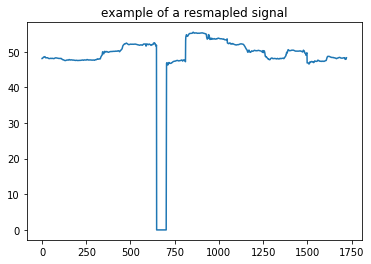

In [13]:
# plot resample example
plt.plot(per_midi_res_train[1])
plt.title("example of a resmapled signal")

## Feature generation
- Compute distance signal from singing and reference midi
- Generate histogram from distance signal

In [14]:
# distance signal train
distance_train = np.stack(ref_midi_res_train - per_midi_res_train)
print(np.min(distance_train))
print(np.max(distance_train))

-76.63777412476107
71.3002150863858


In [15]:
# histogram train
bins = np.linspace(np.floor(np.min(distance_train)), np.ceil(np.max(distance_train)), num=150)
histogram_train = [np.histogram(i, bins=bins, density=True)[0] for i in distance_train]

## Process the test data
- Convert to midi
- resample
- calculate distance signal
- generate histrogram

In [16]:
# convert to midi
per_midi_test, _, _ = f0_to_midi(per_f0_test)
ref_midi_test, _, _ = f0_to_midi(ref_f0_test)

# resample
per_midi_res_test = resample(per_midi_test, avg_len)
ref_midi_res_test = resample(ref_midi_test, avg_len)


# calculate distance signal
distance_test = np.stack(ref_midi_res_test - per_midi_res_test)

# generate histogram
histogram_test = [np.histogram(i, bins=bins, density=True)[0] for i in distance_test]

## Binary classifiers
- Logistic regression CV
- SVM
- Decision tree
- Random forest
- MLP

In [31]:
# logistic regression cross validation
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, max_iter = 100, solver = 'liblinear', random_state=0).fit(histogram_train, y_train)

print("Logistic Regression CV (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

Logistic Regression CV (balanced data):

train accuracy:  0.7811764705882352

test accuracy:  0.7570093457943925
test f1-score macro:  0.7552779732582688
test f1-score micro:  0.7570093457943925

Confusion matrix: 
 [[36 18]
 [ 8 45]]


In [34]:
# svm linear
from sklearn import svm
clf = svm.SVC(kernel='linear', random_state=0).fit(histogram_train, y_train)

print("SVM (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

SVM (balanced data):

train accuracy:  0.7247058823529412

test accuracy:  0.7383177570093458
test f1-score macro:  0.7355225988700566
test f1-score micro:  0.7383177570093457

Confusion matrix: 
 [[34 20]
 [ 8 45]]


In [41]:
# decision tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=1).fit(histogram_train, y_train)

print("Decision tree (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

Decision tree (balanced data):

train accuracy:  1.0

test accuracy:  0.6915887850467289
test f1-score macro:  0.6876603272888102
test f1-score micro:  0.6915887850467289

Confusion matrix: 
 [[31 23]
 [10 43]]


In [59]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0).fit(histogram_train, y_train)

print("Random forest (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

Random forest (balanced data):

train accuracy:  1.0

test accuracy:  0.7850467289719626
test f1-score macro:  0.7838383838383838
test f1-score micro:  0.7850467289719625

Confusion matrix: 
 [[38 16]
 [ 7 46]]


In [72]:
# MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                    hidden_layer_sizes=(5,2), random_state=2).fit(histogram_train, y_train)

print("MLP (balanced data):\n")
print("train accuracy: ", clf.score(histogram_train, y_train))
print("\ntest accuracy: ", clf.score(histogram_test, y_test))
y_pred = clf.predict(histogram_test)

from sklearn.metrics import accuracy_score, f1_score
# accuracy_score(y_test, y_pred)
print("test f1-score macro: ", f1_score(y_test, y_pred, average='macro'))
print("test f1-score micro: ", f1_score(y_test, y_pred, average='micro'))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n", cm)

MLP (balanced data):

train accuracy:  0.7623529411764706

test accuracy:  0.7570093457943925
test f1-score macro:  0.7559649122807017
test f1-score micro:  0.7570093457943925

Confusion matrix: 
 [[37 17]
 [ 9 44]]


## Baseline method results

| Classifier | Train accuracy | Test accuracy |
| :-----:| :----: | :----: |
| Losigtic Regression | 0.781 | 0.757 |
| SVM linear | 0.724 | 0.738 |
| Decision Tree | 1.0 | 0.691 |
| Random Forest | 1.0 | 0.785 |
| Multi-Layer Perceptron | 0.762 | 0.757 |

## Result visualization

In [79]:
y_predict = RandomForestClassifier(n_estimators=50, random_state=0).fit(histogram_train, y_train).predict(histogram_test)

2 1 1


Text(0.5, 1.0, 'TP: true positive')

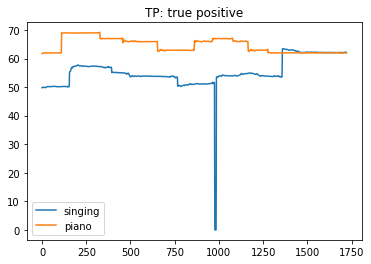

In [80]:
# TP: true positive
for i in range(len(y_predict)):
    if y_predict[i] == 1 and y_test[i] == 1:
        break
print(i, y_predict[i], y_test[i]) 

clf.predict(histogram_test[i:i+1])
plt.plot(per_midi_res_test[i], label="singing")
plt.plot(ref_midi_res_test[i], label="piano")
plt.legend()
plt.title('TP: true positive')

0 0 0


Text(0.5, 1.0, 'TN: true negative')

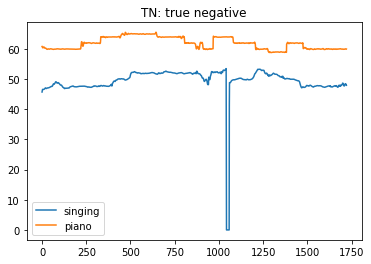

In [82]:
# TN: true negative
for i in range(len(y_predict)):
    if y_predict[i] == 0 and y_test[i] == 0:
        break
print(i, y_predict[i], y_test[i]) 

clf.predict(histogram_test[i:i+1])
plt.plot(per_midi_res_test[i], label="singing")
plt.plot(ref_midi_res_test[i], label="piano")
plt.legend()
plt.title('TN: true negative')

5 1 0


Text(0.5, 1.0, 'FP: false positive')

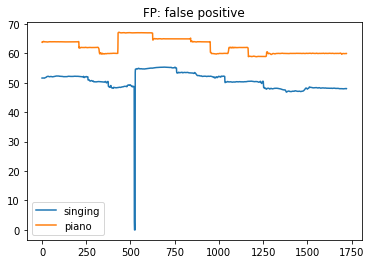

In [86]:
# FP: false positive
for i in range(len(y_predict)):
    if y_predict[i] == 1 and y_test[i] == 0:
        break
print(i, y_predict[i], y_test[i]) 

clf.predict(histogram_test[i:i+1])
plt.plot(per_midi_res_test[i], label="singing")
plt.plot(ref_midi_res_test[i], label="piano")
plt.legend()
plt.title('FP: false positive')

6 0 1


Text(0.5, 1.0, 'FN: false negative')

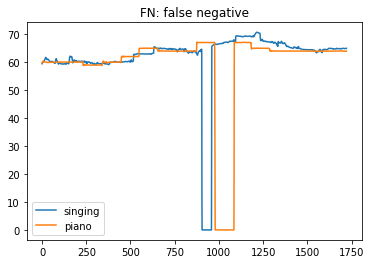

In [87]:
# FN: false negative
for i in range(len(y_predict)):
    if y_predict[i] == 0 and y_test[i] == 1:
        break
print(i, y_predict[i], y_test[i]) 

clf.predict(histogram_test[i:i+1])
plt.plot(per_midi_res_test[i], label="singing")
plt.plot(ref_midi_res_test[i], label="piano")
plt.legend()
plt.title('FN: false negative')